# CNN-based Malware Classification with Malimg Dataset

* Prepare by **vomtung@gmail.com**
* Dataset: Malimg - Malware visualization images
* Model: Convolutional Neural Network (CNN)

In [19]:
# Install required packages
%pip install tensorflow keras opencv-python pillow matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.18.0
GPU Available: []


In [20]:
# Load Malimg dataset
print("=== LOADING MALIMG DATASET ===")

dataset_path = 'dataset/malimg/malimg_paper_dataset_imgs'
image_size = (64, 64)  # Resize images to 64x64

# Check if dataset path exists
if not os.path.exists(dataset_path):
    print(f"ERROR: Dataset path '{dataset_path}' does not exist!")
    print(f"Current working directory: {os.getcwd()}")
else:
    print(f"Dataset path found: {dataset_path}")
    print(f"Full path: {os.path.abspath(dataset_path)}")

# Get all malware family folders (these are the labels)
malware_families = []
if os.path.exists(dataset_path):
    all_items = os.listdir(dataset_path)
    print(f"\nAll items in dataset folder: {all_items}")
    
    malware_families = [d for d in all_items 
                       if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith('.')]
    print(f"\nFound {len(malware_families)} malware families:")
    for family in malware_families:
        family_path = os.path.join(dataset_path, family)
        num_files = len([f for f in os.listdir(family_path) if os.path.isfile(os.path.join(family_path, f))])
        print(f"  - {family}: {num_files} files")

# Load images and labels from each malware family folder
images = []
labels = []

print("\n=== LOADING IMAGES ===")
for family in malware_families:
    family_path = os.path.join(dataset_path, family)
    
    # Get all files in this family folder
    all_files = os.listdir(family_path)
    
    # Filter image files (including .png which is common in Malimg)
    image_files = [f for f in all_files 
                   if os.path.isfile(os.path.join(family_path, f)) and 
                   f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    print(f"\nProcessing '{family}':")
    print(f"  Total files: {len(all_files)}")
    print(f"  Image files: {len(image_files)}")
    
    if len(image_files) > 0:
        print(f"  Sample files: {image_files[:3]}")
    
    loaded_count = 0
    error_count = 0
    
    for img_file in image_files:
        img_path = os.path.join(family_path, img_file)
        try:
            # Read image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                # Resize image to target size
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(family)  # Family name is the label
                loaded_count += 1
            else:
                error_count += 1
                if error_count <= 3:  # Show first 3 errors
                    print(f"  WARNING: cv2.imread returned None for {img_file}")
                
        except Exception as e:
            error_count += 1
            if error_count <= 3:
                print(f"  ERROR loading {img_file}: {e}")
    
    print(f"  Successfully loaded: {loaded_count} images")
    if error_count > 0:
        print(f"  Failed to load: {error_count} images")

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"\n=== DATASET SUMMARY ===")
print(f"Total images loaded: {len(images)}")

if len(images) == 0:
    print("ERROR: No images were loaded!")
    print("Please check:")
    print("1. Malware family folders contain image files")
    print("2. Image files have correct extensions (.png, .jpg, etc.)")
    print("3. Image files are not corrupted")
else:
    print(f"Image shape: {images[0].shape}")
    print(f"Number of malware families (classes): {len(np.unique(labels))}")
    
    # Display class distribution
    unique, counts = np.unique(labels, return_counts=True)
    class_distribution = pd.DataFrame({'Malware Family': unique, 'Count': counts})
    class_distribution = class_distribution.sort_values('Count', ascending=False)
    print("\nClass Distribution:")
    print(class_distribution.to_string(index=False))

=== LOADING MALIMG DATASET ===
Dataset path found: dataset/malimg/malimg_paper_dataset_imgs
Full path: e:\master\github\detect-def-attack-lab\dataset\malimg\malimg_paper_dataset_imgs

All items in dataset folder: ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.gen!g', 'C2LOP.P', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']

Found 25 malware families:
  - Adialer.C: 122 files
  - Agent.FYI: 116 files
  - Allaple.A: 2949 files
  - Allaple.L: 1591 files
  - Alueron.gen!J: 198 files
  - Autorun.K: 106 files
  - C2LOP.gen!g: 200 files
  - C2LOP.P: 146 files
  - Dialplatform.B: 177 files
  - Dontovo.A: 162 files
  - Fakerean: 381 files
  - Instantaccess: 431 files
  - Lolyda.AA1: 213 files
  - Lolyda.AA2: 184 files
  - Lolyda.AA3: 123 files
  - Lolyda.AT: 15

=== VISUALIZING SAMPLE IMAGES ===


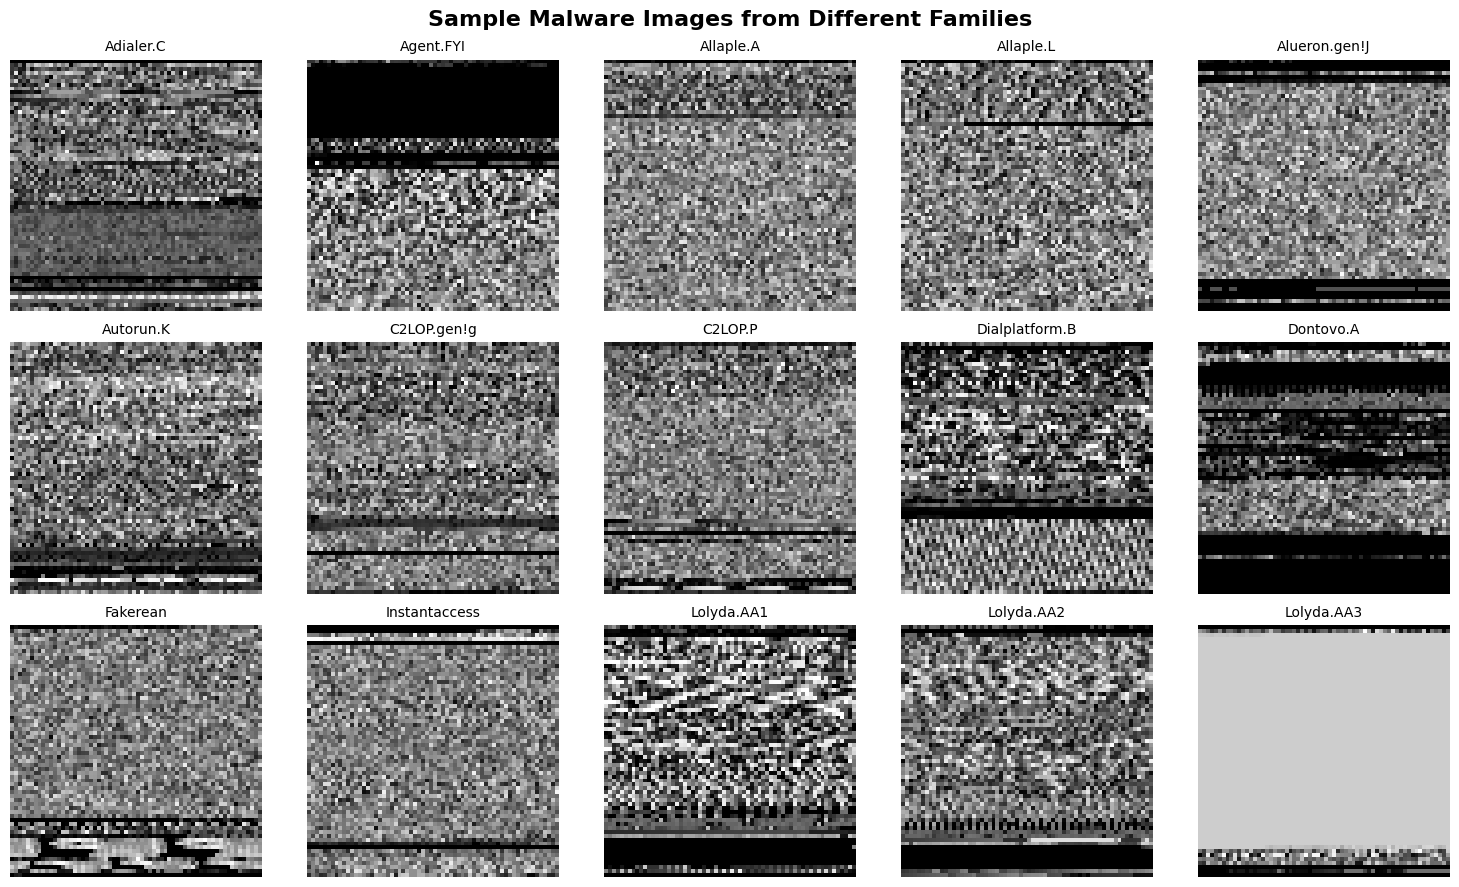

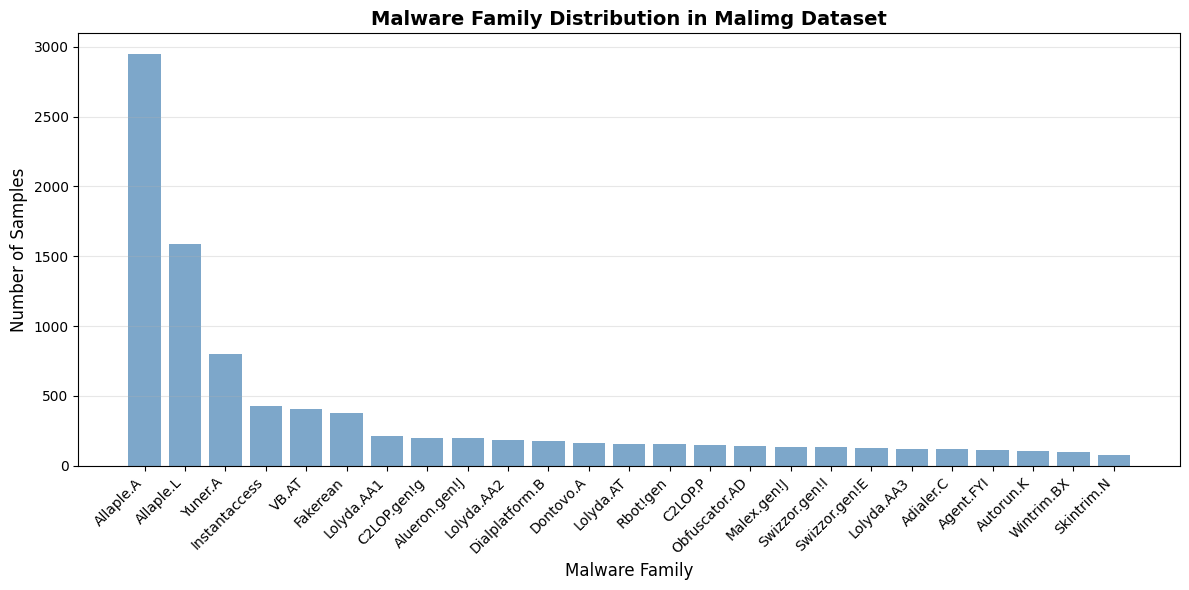

In [21]:
# Visualize sample images from each malware family
print("=== VISUALIZING SAMPLE IMAGES ===")

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Sample Malware Images from Different Families', fontsize=16, fontweight='bold')

for idx, family in enumerate(malware_families[:15]):
    row = idx // 5
    col = idx % 5
    
    # Get first image from this family
    family_indices = np.where(labels == family)[0]
    if len(family_indices) > 0:
        sample_img = images[family_indices[0]]
        axes[row, col].imshow(sample_img, cmap='gray')
        axes[row, col].set_title(family, fontsize=10)
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_distribution['Malware Family'], class_distribution['Count'], color='steelblue', alpha=0.7)
plt.xlabel('Malware Family', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Malware Family Distribution in Malimg Dataset', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Preprocess data for CNN
print("=== PREPROCESSING DATA ===")

# Normalize pixel values to [0, 1]
images_normalized = images.astype('float32') / 255.0

# Reshape for CNN input (add channel dimension)
images_normalized = images_normalized.reshape(-1, image_size[0], image_size[1], 1)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

print(f"Number of classes: {num_classes}")
print(f"Class names: {label_encoder.classes_}")

# Convert labels to categorical (one-hot encoding)
labels_categorical = keras.utils.to_categorical(labels_encoded, num_classes)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    images_normalized, labels_categorical, test_size=0.3, random_state=42, stratify=labels_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"\nData Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Input shape: {X_train.shape[1:]}")

=== PREPROCESSING DATA ===
Number of classes: 25
Class names: ['Adialer.C' 'Agent.FYI' 'Allaple.A' 'Allaple.L' 'Alueron.gen!J'
 'Autorun.K' 'C2LOP.P' 'C2LOP.gen!g' 'Dialplatform.B' 'Dontovo.A'
 'Fakerean' 'Instantaccess' 'Lolyda.AA1' 'Lolyda.AA2' 'Lolyda.AA3'
 'Lolyda.AT' 'Malex.gen!J' 'Obfuscator.AD' 'Rbot!gen' 'Skintrim.N'
 'Swizzor.gen!E' 'Swizzor.gen!I' 'VB.AT' 'Wintrim.BX' 'Yuner.A']

Data Split:
Training set: 6537 samples
Validation set: 1401 samples
Test set: 1401 samples
Input shape: (64, 64, 1)

Data Split:
Training set: 6537 samples
Validation set: 1401 samples
Test set: 1401 samples
Input shape: (64, 64, 1)


In [23]:
# Build CNN Model
print("=== BUILDING CNN MODEL ===")

def create_cnn_model(input_shape, num_classes):
    """
    Create a CNN model for malware image classification
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fully Connected Layer
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]
model = create_cnn_model(input_shape, num_classes)

# Print model summary
model.summary()

=== BUILDING CNN MODEL ===


e:\software\python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,393,081 (9.13 MB)

 Trainable params: 2,391,673 (9.12 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Compile and Train Model

Train CNN model to classify malware families. Configure optimizer and loss function for multi-class classification.

In [28]:
# Compile the model
print("=== COMPILING MODEL ===")

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model compiled successfully!")

=== COMPILING MODEL ===
Model compiled successfully!


In [30]:
# Train the model
print("=== TRAINING MODEL ===")
print(f"Training samples: {X_train.shape[0]}")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Batch size: 32")
print(f"Epochs: 20")

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    verbose=1
)

print("\nTraining completed!")

=== TRAINING MODEL ===
Training samples: 6537
Validation samples: 1401
Batch size: 32
Epochs: 20
Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 153s 749ms/step - accuracy: 0.8554 - loss: 0.5146 - val_accuracy: 0.3155 - val_loss: 5.8571
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 153s 749ms/step - accuracy: 0.8554 - loss: 0.5146 - val_accuracy: 0.3155 - val_loss: 5.8571
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 113s 553ms/step - accuracy: 0.9516 - loss: 0.1784 - val_accuracy: 0.0371 - val_loss: 4.9526
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 113s 553ms/step - accuracy: 0.9516 - loss: 0.1784 - val_accuracy: 0.0371 - val_loss: 4.9526
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 126s 616ms/step - accuracy: 0.9673 - loss: 0.1085 - val_accuracy: 0.9507 - val_loss: 0.1409
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 126s 616ms/step - accuracy: 0.9673 - loss: 0.1085 - val_accuracy: 0.9507 - val_loss: 0.1409
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 158s 771ms/step - accuracy: 0.9775 - loss: 0.0722 - val_accuracy: 0.974

## Training History Visualization

Visualize training progress: Accuracy and Loss over epochs.

=== VISUALIZING TRAINING HISTORY ===


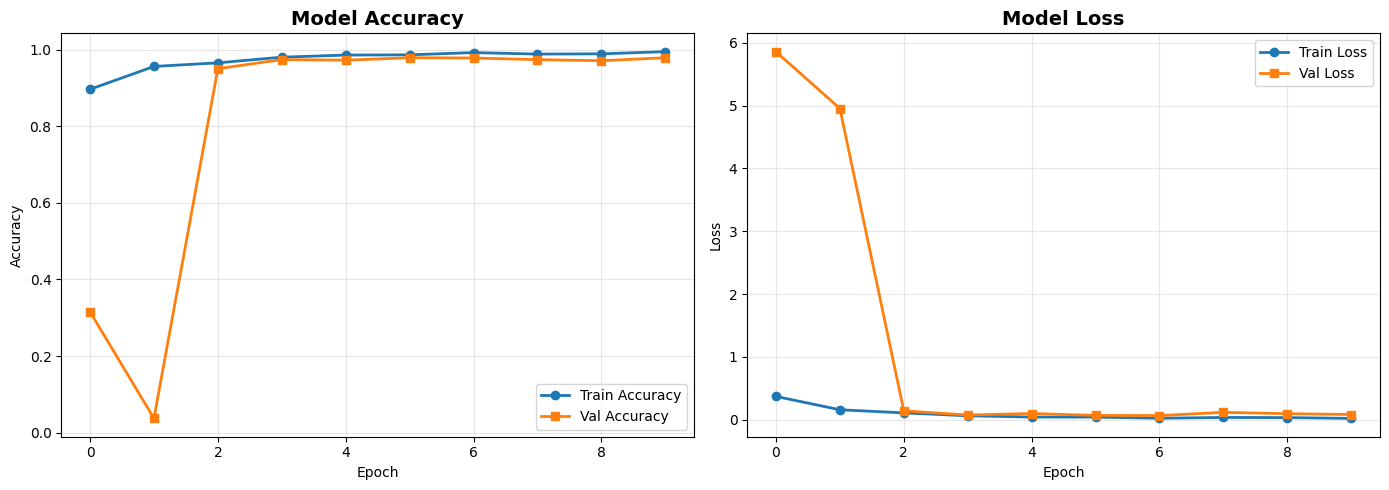


Final Training Accuracy: 0.9951
Final Validation Accuracy: 0.9793


In [31]:
# Plot training history
print("=== VISUALIZING TRAINING HISTORY ===")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o')
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, marker='s')
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

## Model Evaluation on Test Set

Comprehensive evaluation including:
- **Accuracy, Precision, Recall, F1-Score**
- **Confusion Matrix**: Visual representation of predictions
- **Classification Report**: Per-class performance metrics
- **TPR, FPR, FNR**: Additional performance indicators

In [32]:
# Evaluate on test set
print("=== EVALUATING MODEL ON TEST SET ===")

# Get predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate metrics
test_accuracy = accuracy_score(y_test_labels, y_pred)

print(f"\n=== TEST SET PERFORMANCE ===")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Calculate overall metrics
from sklearn.metrics import precision_score, recall_score, f1_score

test_precision = precision_score(y_test_labels, y_pred, average='weighted')
test_recall = recall_score(y_test_labels, y_pred, average='weighted')
test_f1 = f1_score(y_test_labels, y_pred, average='weighted')

print(f"Test Precision (weighted): {test_precision:.4f}")
print(f"Test Recall (weighted): {test_recall:.4f}")
print(f"Test F1-Score (weighted): {test_f1:.4f}")

# Calculate TPR, FPR, FNR for binary classification metrics
# For multi-class, we calculate macro-averages
TN = []
FP = []
FN = []
TP = []

for i in range(num_classes):
    # Create binary classification for class i
    y_true_binary = (y_test_labels == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)
    
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
    tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
    
    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)

# Calculate macro-average rates
TPR_macro = np.mean([TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0 for i in range(num_classes)])
FPR_macro = np.mean([FP[i] / (FP[i] + TN[i]) if (FP[i] + TN[i]) > 0 else 0 for i in range(num_classes)])
FNR_macro = np.mean([FN[i] / (FN[i] + TP[i]) if (FN[i] + TP[i]) > 0 else 0 for i in range(num_classes)])

print(f"\n=== MACRO-AVERAGED RATES ===")
print(f"TPR (True Positive Rate): {TPR_macro:.4f}")
print(f"FPR (False Positive Rate): {FPR_macro:.4f}")
print(f"FNR (False Negative Rate): {FNR_macro:.4f}")

=== EVALUATING MODEL ON TEST SET ===
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step

=== TEST SET PERFORMANCE ===
Test Accuracy: 0.9807
Test Precision (weighted): 0.9815
Test Recall (weighted): 0.9807
Test F1-Score (weighted): 0.9805

=== MACRO-AVERAGED RATES ===
TPR (True Positive Rate): 0.9510
FPR (False Positive Rate): 0.0008
FNR (False Negative Rate): 0.0490

=== TEST SET PERFORMANCE ===
Test Accuracy: 0.9807
Test Precision (weighted): 0.9815
Test Recall (weighted): 0.9807
Test F1-Score (weighted): 0.9805

=== MACRO-AVERAGED RATES ===
TPR (True Positive Rate): 0.9510
FPR (False Positive Rate): 0.0008
FNR (False Negative Rate): 0.0490


In [33]:
# Classification Report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
class_names = label_encoder.classes_
report = classification_report(y_test_labels, y_pred, target_names=class_names, digits=4)
print(report)


=== DETAILED CLASSIFICATION REPORT ===
                precision    recall  f1-score   support

     Adialer.C     1.0000    1.0000    1.0000        18
     Agent.FYI     1.0000    1.0000    1.0000        18
     Allaple.A     1.0000    1.0000    1.0000       443
     Allaple.L     1.0000    1.0000    1.0000       239
 Alueron.gen!J     1.0000    1.0000    1.0000        29
     Autorun.K     1.0000    1.0000    1.0000        16
       C2LOP.P     0.8333    0.6818    0.7500        22
   C2LOP.gen!g     0.7941    0.9000    0.8438        30
Dialplatform.B     1.0000    1.0000    1.0000        27
     Dontovo.A     1.0000    1.0000    1.0000        24
      Fakerean     0.9825    0.9825    0.9825        57
 Instantaccess     1.0000    1.0000    1.0000        65
    Lolyda.AA1     1.0000    1.0000    1.0000        32
    Lolyda.AA2     1.0000    1.0000    1.0000        28
    Lolyda.AA3     1.0000    1.0000    1.0000        19
     Lolyda.AT     1.0000    1.0000    1.0000        24
   Male

=== CONFUSION MATRIX ===


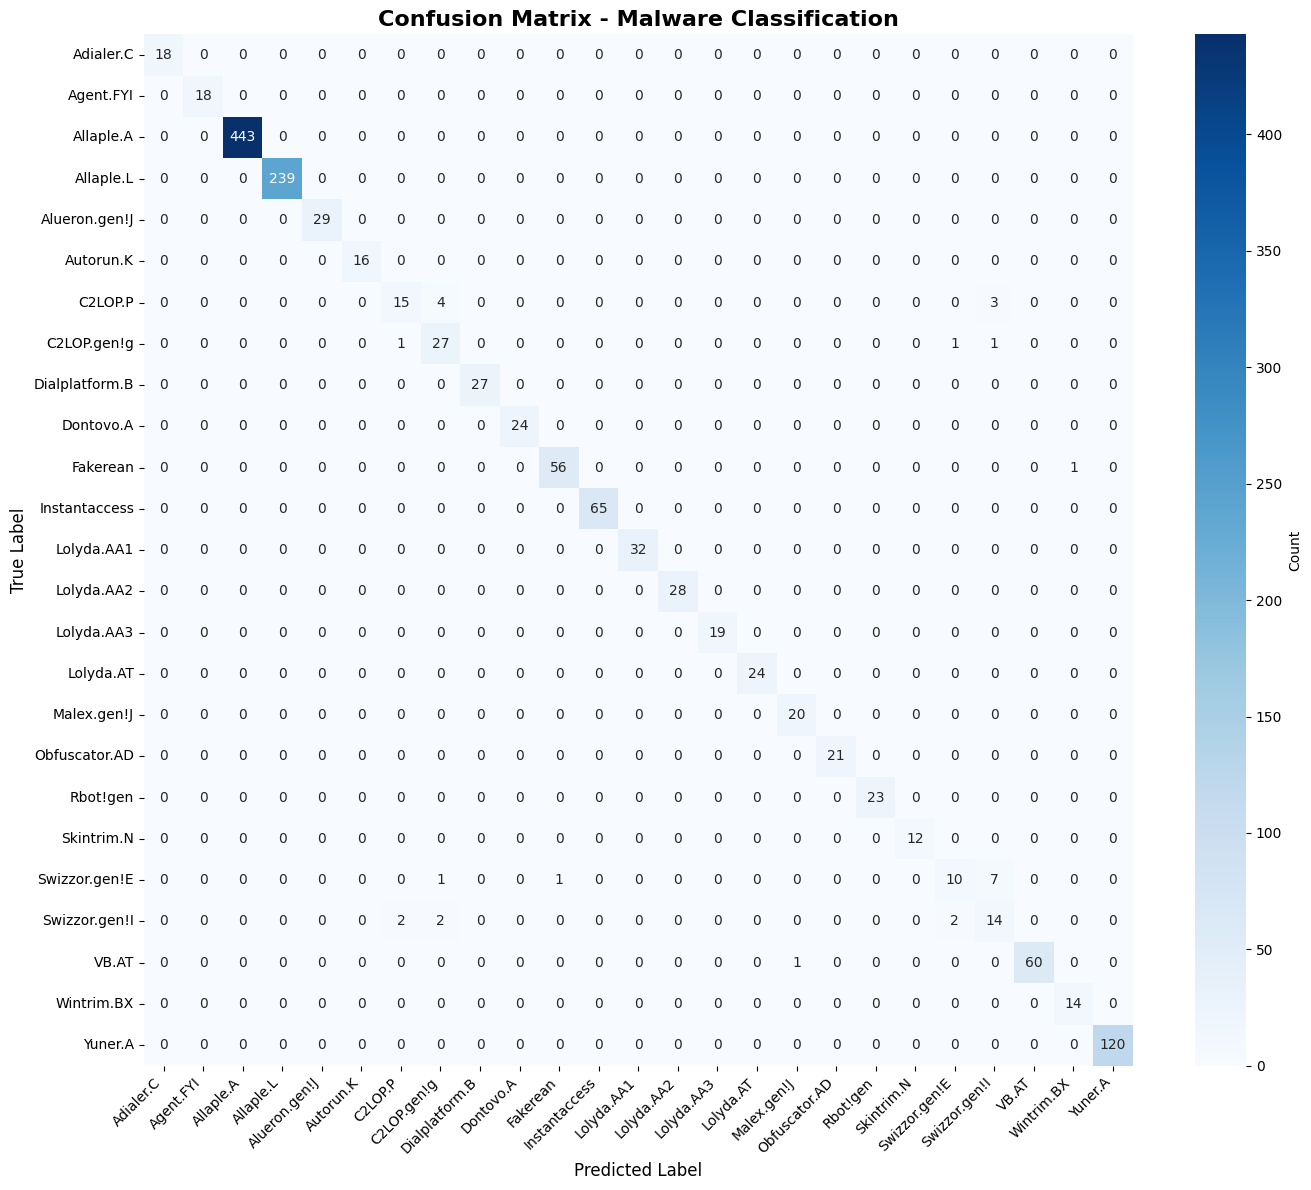

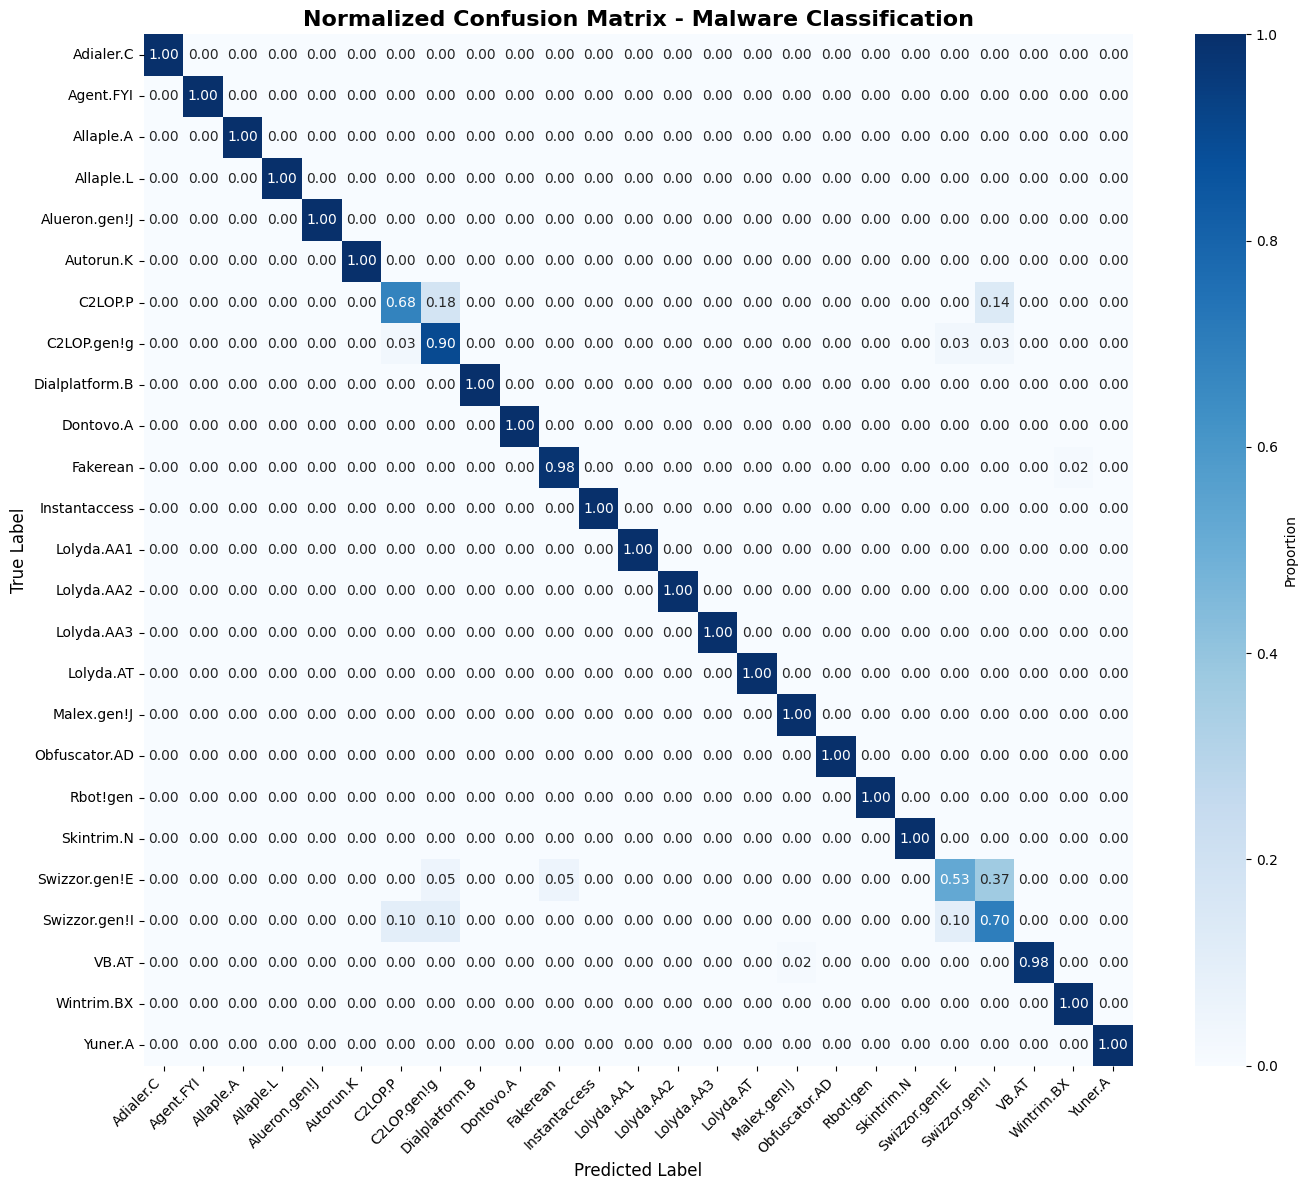

In [34]:
# Plot confusion matrix
print("=== CONFUSION MATRIX ===")

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Malware Classification', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
plt.figure(figsize=(14, 12))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names,
            cbar_kws={'label': 'Proportion'})
plt.title('Normalized Confusion Matrix - Malware Classification', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

=== PER-CLASS PERFORMANCE ===
Malware Family  Precision   Recall  F1-Score  Support
     Adialer.C   1.000000 1.000000  1.000000       18
     Agent.FYI   1.000000 1.000000  1.000000       18
     Allaple.A   1.000000 1.000000  1.000000      443
     Allaple.L   1.000000 1.000000  1.000000      239
 Alueron.gen!J   1.000000 1.000000  1.000000       29
     Autorun.K   1.000000 1.000000  1.000000       16
Dialplatform.B   1.000000 1.000000  1.000000       27
 Instantaccess   1.000000 1.000000  1.000000       65
     Dontovo.A   1.000000 1.000000  1.000000       24
    Skintrim.N   1.000000 1.000000  1.000000       12
       Yuner.A   1.000000 1.000000  1.000000      120
    Lolyda.AA1   1.000000 1.000000  1.000000       32
    Lolyda.AA2   1.000000 1.000000  1.000000       28
     Lolyda.AT   1.000000 1.000000  1.000000       24
    Lolyda.AA3   1.000000 1.000000  1.000000       19
      Rbot!gen   1.000000 1.000000  1.000000       23
 Obfuscator.AD   1.000000 1.000000  1.000000       2

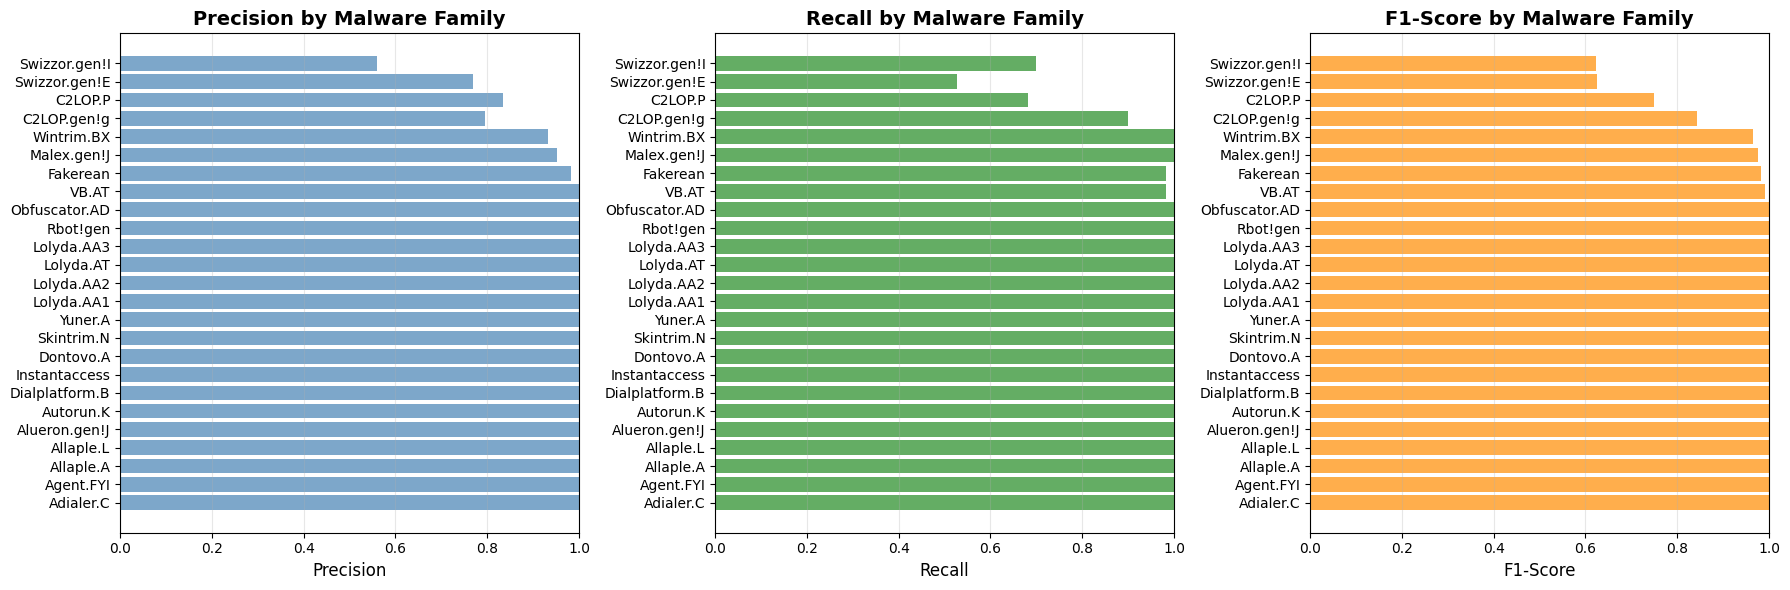

In [35]:
# Per-class performance visualization
print("=== PER-CLASS PERFORMANCE ===")

from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
    y_test_labels, y_pred, labels=range(num_classes)
)

# Create dataframe for better visualization
performance_df = pd.DataFrame({
    'Malware Family': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support
})

performance_df = performance_df.sort_values('F1-Score', ascending=False)
print(performance_df.to_string(index=False))

# Plot per-class metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision
axes[0].barh(performance_df['Malware Family'], performance_df['Precision'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Precision', fontsize=12)
axes[0].set_title('Precision by Malware Family', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
axes[0].grid(axis='x', alpha=0.3)

# Recall
axes[1].barh(performance_df['Malware Family'], performance_df['Recall'], color='forestgreen', alpha=0.7)
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_title('Recall by Malware Family', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].grid(axis='x', alpha=0.3)

# F1-Score
axes[2].barh(performance_df['Malware Family'], performance_df['F1-Score'], color='darkorange', alpha=0.7)
axes[2].set_xlabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score by Malware Family', fontsize=14, fontweight='bold')
axes[2].set_xlim([0, 1])
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()